In [11]:
import numpy as np
import torch
import torch.nn as nn
from dataset import CityscapesDataset
from torchvision.datasets import Cityscapes
from unet import *
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os 


In [12]:
# ALL CREDITS TO https://github.com/goldbattle/pytorch_unet/blob/master/script_train.py FOR DATASET CLASS!
img_data = CityscapesDataset("/Users/charlesdowns/Desktop/cityscapes_mini/", split='train', mode='fine')
img_batch = torch.utils.data.DataLoader(img_data, batch_size=1, shuffle=True)

In [13]:
# Hyperparameters and stuff
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

# Set model parameters
epochs = 10
learning_rate = 0.001

# Create the model
Net = UNet(3, img_data.num_classes, 64)
Net.to(device)
train_loss = []

# Since our goal here is to segment, we will use the cross entropy loss function and 4 classes (background, road, sky, car)
criterion = nn.CrossEntropyLoss() # for segment loss. could also be reconstruction loss, then it is N1 loss 
num_classes = img_data.num_classes
print(num_classes)
optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)

mps
4


/Users/charlesdowns/miniconda3/envs/dl/lib/python3.10/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Epoch: 1/10, Batch: 1/85, Loss: 1.3965


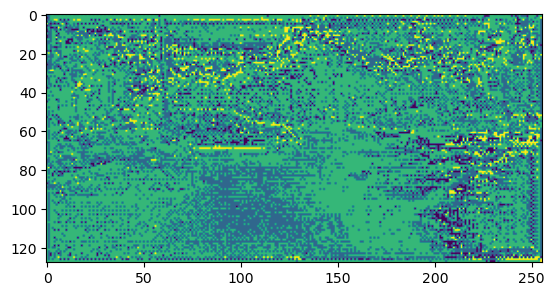

KeyboardInterrupt: 

In [14]:
for epoch in range(epochs): 
    # TODO: use tqdm for progress bar
    for idx_batch, (imagergb, labelmask, labelrgb) in enumerate(img_batch):
        imagergb = imagergb.to(device)
        labelmask = labelmask.to(device)
        labelrgb = labelrgb.to(device)
        # print(imagergb.shape)
        optimizer.zero_grad()
        output = Net(imagergb)
        loss = criterion(output, labelmask)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        if idx_batch % 50 == 0:
            print("Epoch: {}/{}, Batch: {}/{}, Loss: {:.4f}".format(epoch+1, epochs, idx_batch+1, len(img_batch), loss.item()))
            # show output
            output = torch.argmax(output, dim=1)
            output = output.detach().cpu().numpy()
            output = np.squeeze(output)
            plt.imshow(output)
            plt.show()

In [ ]:
# Plot the training loss
plt.plot(train_loss)
plt.title("Train Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

# Save the model
torch.save(Net.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")